<a href="https://colab.research.google.com/github/Flychuban/Tyres-Condition/blob/main/TyreCondition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/training_data')
test_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/testing_data')
RANDOM_SEED = 10
EPOCHS = 100
BATCH_SIZE = 16

In [3]:
labels = os.listdir(train_path)
labels

['normal', 'cracked']

Let's make our dataset

In [4]:
def process_data(data):
  # creating instance of labelencoder

  path = Path(data)
  filepaths = list(path.glob(r'*/*.jpg'))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it

  print(labels)
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df = pd.concat([df1, df2], axis=1)
  return df

In [5]:
train_data = process_data(train_path)
test_data = process_data(test_path)
train_data

['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',

,filepaths,labels
0,/content/drive/MyDrive/TyreConditionPrediction...,normal
1,/content/drive/MyDrive/TyreConditionPrediction...,normal
2,/content/drive/MyDrive/TyreConditionPrediction...,normal
3,/content/drive/MyDrive/TyreConditionPrediction...,normal
4,/content/drive/MyDrive/TyreConditionPrediction...,normal
...,...,...
668,/content/drive/MyDrive/TyreConditionPrediction...,cracked
669,/content/drive/MyDrive/TyreConditionPrediction...,cracked
670,/content/drive/MyDrive/TyreConditionPrediction...,cracked
671,/content/drive/MyDrive/TyreConditionPrediction...,cracked


In [6]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8],)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8],
                                    validation_split=0.5)

In [7]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED)

test_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 x_col='filepaths',
                                                 y_col = 'labels',
                                                 class_mode='binary',
                                                 random_seed = RANDOM_SEED,
                                                 subset='training'
                                                 )

val_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED,
                                                   subset="validation"
                                                )


Found 673 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


Build the model

In [8]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights = 'imagenet',
    pooling='max'
)

94765736/94765736 [==============================] - 3s 0us/step


In [9]:
pretrained_model.trainable = False # we make this cuz w don't train again the big model

In [10]:
inputs = pretrained_model.input

new_layer = Dense(120, activation='relu')(pretrained_model.output)
Dropout(0.3)
new_layer = Dense(240, activation ='relu')(new_layer)
Dropout(0.5)
new_layer = Dense(60, activation ='relu')(new_layer)

outputs = Dense(1, activation = 'sigmoid')(new_layer)

In [11]:
model = Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [13]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

In [14]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

Training

In [15]:
history = model.fit(train_images,
                    epochs=100,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    callbacks=[early_stop]
                    )

Epoch 1/100
43/43 [==============================] - 406s 9s/step - loss: 0.4442 - accuracy: 0.8529 - val_loss: 0.3271 - val_accuracy: 0.8700
Epoch 2/100
43/43 [==============================] - 48s 1s/step - loss: 0.1719 - accuracy: 0.9450 - val_loss: 0.0556 - val_accuracy: 0.9800
Epoch 3/100
43/43 [==============================] - 50s 1s/step - loss: 0.1266 - accuracy: 0.9599 - val_loss: 0.1160 - val_accuracy: 0.9600
Epoch 4/100
43/43 [==============================] - 52s 1s/step - loss: 0.0887 - accuracy: 0.9643 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 5/100
43/43 [==============================] - 47s 1s/step - loss: 0.1314 - accuracy: 0.9510 - val_loss: 5.8252e-04 - val_accuracy: 1.0000
Epoch 6/100
43/43 [==============================] - 49s 1s/step - loss: 0.0775 - accuracy: 0.9703 - val_loss: 0.1020 - val_accuracy: 0.9800
Epoch 7/100
43/43 [==============================] - 48s 1s/step - loss: 0.0770 - accuracy: 0.9643 - val_loss: 0.0508 - val_accuracy: 0.9900
Epoch 8/

In [16]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

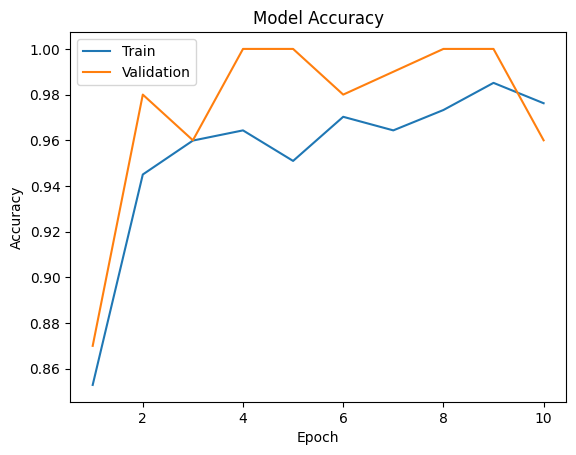

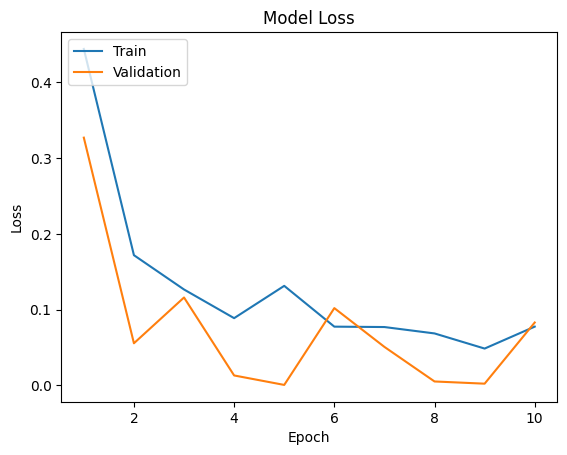

In [18]:
plotLearningCurve(history,10)

In [19]:
model.evaluate(test_images)

7/7 [==============================] - 51s 8s/step - loss: 0.1250 - accuracy: 0.9604


[0.12501336634159088, 0.9603960514068604]

In [35]:
model.save("tyre_condition_model_8_best.h5")

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TyreConditionPrediction/tyre_condition_model_4.h5')

KeyboardInterrupt: ignored

In [34]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/TyreConditionPrediction/tyre5_img.jfif', target_size = (224, 224)) # Get the image
transformed_image = image.img_to_array(test_image) # Transform image to array
transformed_image = np.expand_dims(transformed_image, axis=0) # Expand dims to make a batch of 1 image
prediction = model.predict(transformed_image)

print(prediction)

if prediction[0] < 0.5:
  print("This tyre HAS a problem!")
else:
  print("This tyre HASN'T problem!")

1/1 [==============================] - 0s 24ms/step
[[0.01468564]]
This tyre HAS a problem!
